# Intro
In this report, we look at left hemisphere MANIA 1.0 results for seven HCP subjects with MMP1.0 parcellation

### Operating Point
Let's first look at **(density, threshold, NAR)** operating points. On the scatter plot, you can hover to see the NAR information. NARs are scaled by 100 for visualization purposes.

In [1]:
from py2neo import Node, Relationship, Graph
from numpy.random import rand
import numpy as num
from bokeh.plotting import output_notebook,figure,ColumnDataSource, show
from bokeh.layouts import row,column,gridplot
from bokeh.models import HoverTool
from utils import *
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### JACCARD SIMILARITY
Next we look at the jaccard similarity between each pair of subject networks

In [7]:
# NEO4J database call for results
graph = Graph()
c1 = '''MATCH (:MANIA)-[r]-(n:RES)
 return r.SUBJECT as sub, n.threshold as t,n.density as d,n.NAR as nar, n.hemisphere as hem'''
A = graph.run(c1)
# Plotting the data
s = []
hover = HoverTool(tooltips=[
    ("NAR", "$NAR"),
    ("SUBJECT", "$SUB"),
])
sub = []
t = []
d = []
nar = []
hem = []
for i,w in enumerate(A):
    sub = sub + [w['sub']]
    hem = hem + [w['hem']]
    nar = nar + [w['nar']*100]
    d = d + [w['d']*100]
    t = t + [w['t']]
source = ColumnDataSource(data=dict(
    sub=sub,
    t=t,
    d=d,
    nar=nar,
    hem=hem
))
hover = HoverTool(tooltips=[
    ("NAR", "@nar"),
    ("SUBJECT", "@sub"),
    ("HEMISPHERE", "@hem")
])
p = figure(plot_width=500, plot_height=500, tools=[hover],title="MANIA 1.0 Operating points",y_axis_label = "density",x_axis_label = "threshold")
p.circle('t', 'd', size=20, source=source)
show(p)

In [15]:
c0 = '''MATCH (n:ROI)-[r:MANIA{connected:1}]->(m:ROI)
 return n.name as N1,m.name as N2,r.SUBJECT as sub'''
c = [c0]

for t in [1600,1800,2000,2200,2400,2600,2800,3000]:
    tmp = '''MATCH (n:ROI)-[r:THRESHOLD{connected:1,T:XXX}]->(m:ROI)
    return n.name as N1,m.name as N2,r.SUBJECT as sub'''.replace('XXX',str(t))
    c = c + [tmp]
D = []
for c1 in c:
    A = graph.run(c1)
    net = {}
    E = {}
    for w in A:
        try:
            E[w['N1']+w['N2']] += 1
        except KeyError:
            E[w['N1']+w['N2']] = 1
        i = int(w['N1'][1:])-1
        j = int(w['N2'][1:])-1
        try:
            net[w['sub']][i,j] = 1
        except KeyError:
            net[w['sub']]=num.zeros((180,180))
    from itertools import combinations
    S = sorted(net.keys())
    A =  num.zeros((6,6))
    for i in range(6):
        A[i,i] = 1.0
    Z = []
    for w,v in combinations(S,2):
        tmp = sim(net[w],net[v])
        A[S.index(w),S.index(v)] = tmp
        A[S.index(v),S.index(w)] = tmp
        Z = Z + [tmp]
    D.append((A,Z))
#     from collections import Counter
#     c = Counter(list(E.values()))
#     per = []
#     K=[]
#     for v in c:
#         per = per + [int(c[v]*100/len(E))]
#         K = K + [v]
#     cc = sorted(zip(K,per),reverse=True)
#     per = [xx[1] for xx in cc]
#     K = [xx[0] for xx in cc]

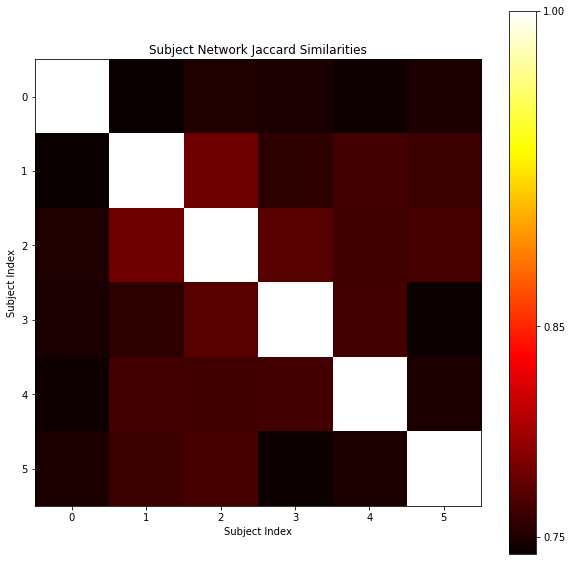

In [14]:
plt.figure(figsize=(10, 10))
cax = plt.imshow(A, cmap='hot', interpolation='nearest')
plt.title("Subject Network Jaccard Similarities")
plt.xlabel("Subject Index")
plt.ylabel("Subject Index")
cbar = plt.colorbar(cax, ticks=[0.75, 0.85, 1], orientation='vertical')
cbar.ax.set_xticklabels(['0.75', '0.85', '1'])  # horizontal colorbar
plt.show()

| Subject 1        | Subject2           | Jaccard Similarity (100%)  |
| ------------- |:-------------:| -----:|
| 0| 1 |80.0  |
| 0| 2 |79.0  |
| 0| 3 |77.0  |
| 0| 4 |76.0  |
| 0| 5 |78.0  |
| 0| 6 |80.0  |
| 1| 2 |81.0  |
| 1| 3 |79.0  |
| 1| 4 |78.0  |
| 1| 5 |81.0  |
| 1| 6 |80.0  |
| 2| 3 |77.0  |
| 2| 4 |77.0  |
| 2| 5 |79.0  |
| 2| 6 |80.0  |
| 3| 4 |75.0  |
| 3| 5 |77.0  |
| 3| 6 |78.0  |
| 4| 5 |78.0  |
| 4| 6 |76.0  |
| 5| 6 |80.0  |

9


{'boxes': [<matplotlib.lines.Line2D at 0x10761a2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x10761acc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1075f8a20>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1075f85c0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x10761a2e8>,
  <matplotlib.lines.Line2D at 0x10dea10b8>]}

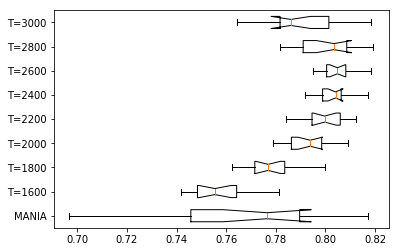

In [29]:
plt.figure()
print(len(D))
labels=['MANIA','T=1600','T=1800','T=2000','T=2200','T=2400','T=2600','T=2800','T=3000']
plt.boxplot([xx[1] for xx in D], i, 'rs', 0,labels=labels)
plt.
# plt.boxplot(D[0][1], i, 'rs', 0)